# Estimate the historic mining area of a single mine

In this notebook, the sam-geo model will be used to analyze the historic mining area of a single mine. 

In [1]:
# !pip install segment-geospatial

In [2]:
import sys
sys.path.append("..")

from samgeo import SamGeo
import leafmap
import glob

from src.data.get_satellite_images import ReadSTAC
from src.visualization.visualize import plot_area_per_year, plot_multiple_masks_on_images

# Setup

## Mine and Years

In [3]:
MINE_POINT = [-50.16556135114535, -6.060451692157381]
BUFFER = 5
YEARS = list(range(1985, 2021, 5))
print(YEARS)

[1985, 1990, 1995, 2000, 2005, 2010, 2015, 2020]


## Data Provider API

In [4]:
# Option 1 (Default): Read from Planetary Computer STAC API
API_URL="https://planetarycomputer.microsoft.com/api/stac/v1"
BANDS = ['B04', 'B03', 'B02']
BANDS_LANDSAT = ['red', 'green', 'blue']

# Option 2: Read from AWS STAC API
# API_URL="https://earth-search.aws.element84.com/v1"
# BANDS = ['red', 'green', 'blue']
# BANDS_LANDSAT = ['red', 'green', 'blue']


## Collection
Select either Sentinel or Landsat Images. 

Sentinel provide higher resolution, but are only available since 2015.

Landsat images are available since 1972. However, I found that for some of the early years, no images are available. 
Also, it seems that Landsat images older than 2003 have the issue of striping, see [here](https://gis.stackexchange.com/questions/84319/destriping-landsat-7-images) for details. Therefore, for Landsat images, it is recommended to use the ``TAKE_BEST_N`` argument, using the ``n`` least cloudy images and mosaicing any missing pixels. 

In [ ]:
# Option 1: Sentinel
# COLLECTION = "sentinel-2-l2a"
# RESOLUTION = 10
# TAKE_BEST_N = 1

# Option 2: Landsat
COLLECTION = "landsat-c2-l2"
RESOLUTION = 30
TAKE_BEST_N = 3

## Define classes

In [ ]:
stac_reader = ReadSTAC(api_url=API_URL, collection=COLLECTION)

In [ ]:
# Docs: https://samgeo.gishub.org/samgeo/#samgeo.samgeo.SamGeo.__init__
sam = SamGeo(
    model_type="vit_l", # vit_h (2.4GB), vit_l (1.2GB), vit_b(~300MB)
    automatic=False,
    # device="cuda",
    sam_kwargs=None,
)

## Optional: Use bounding box instead of point as prompt for SAM

By default, the ``MINE_POINT`` is used as input prompt for the SAM model. 
However, for better segmentation performance, a bounding box can be drawn around the mining area that should be segmented. 
The bounding box will be used as input prompt for the SAM model 

In [6]:
# initialize leafmap and optionally draw a bounding box
m = leafmap.Map(center = [MINE_POINT[1], MINE_POINT[0]], zoom = 13, height="800px")
m.add_basemap("SATELLITE")
m

Map(center=[-6.060451692157381, -50.16556135114535], controls=(ZoomControl(options=['position', 'zoom_in_text'…

In [7]:
if m.user_rois is not None:
    sam_prompt_box = m.user_rois
    sam_prompt_point = None
else: 
    sam_prompt_box = None
    sam_prompt_point = [MINE_POINT]

print("Prompt Box:", sam_prompt_box)
print("Prompt Point:", sam_prompt_point)

Prompt Box: {'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {}, 'geometry': {'type': 'Polygon', 'coordinates': [[[-50.206146, -6.120927], [-50.206146, -6.018507], [-50.102463, -6.018507], [-50.102463, -6.120927], [-50.206146, -6.120927]]]}}]}
Prompt Point: None


# Perform Segmentation

In [51]:
for year in YEARS:
    print(f"Year: {year}")

    # check available items
    items = stac_reader.get_items(
        location = MINE_POINT,
        buffer=10,
        timerange=f'{year}-01-01/{year}-12-31',
        max_cloud_cover=10
    )

    # download least cloudy image
    stack = stac_reader.get_stack(
        items, 
        filter_by="least_cloudy", 
        take_best_n=TAKE_BEST_N,
        bands=BANDS_LANDSAT, 
        resolution=RESOLUTION
        )
    
    stack_stretched = stac_reader.stretch_contrast_stack(stack)
    image_path = stac_reader.save_stack_as_geotiff(stack_stretched, f"{year}.tif")

    # provide image to samgeo
    sam.set_image(image_path)

    # create output file path for mask
    mask_path = image_path.replace(".tif", "_mask.tif")

    # predict mask
    sam.predict(
        point_coords=sam_prompt_point,
        boxes=sam_prompt_box, 
        point_labels=1, 
        point_crs="EPSG:4326", 
        output=mask_path
    )

    # convert mask to polygons
    mask_polygon_path = mask_path.replace(".tif", ".gpkg")
    sam.raster_to_vector(mask_path, mask_polygon_path)

    # add mask to map
    style = {
        "color": "#3388ff",
        "weight": 2,
        "fillColor": "#7c4185",
        "fillOpacity": 0.5,
    }
    m.add_vector(mask_polygon_path, layer_name=f"{year} Mask", style=style)


Year: 1985
2 Items found.
Loading stack...
Found 1 unique tile ids.
Choosing the best 3 items.For unique tile 224_064, choosing ['LT05_L2SP_224064_19850227_02_T2', 'LT05_L2SP_224064_19850518_02_T2'] from [datetime.date(1985, 2, 27), datetime.date(1985, 5, 18)] with [0.0, 7.0]% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: /workspaces/mine-segmentation/data/interim/1985.tif
Year: 1990
2 Items found.
Loading stack...
Found 1 unique tile ids.
Choosing the best 3 items.For unique tile 224_064, choosing ['LT05_L2SP_224064_19900601_02_T1', 'LT05_L2SP_224064_19900804_02_T1'] from [datetime.date(1990, 6, 1), datetime.date(1990, 8, 4)] with [7.0, 8.0]% cloud cover
Stretching contrast...
Saving stack as GeoTIFF under: /workspaces/mine-segmentation/data/interim/1990.tif
Year: 1995
2 Items found.
Loading stack...
Found 1 unique tile ids.
Choosing the best 3 items.For unique tile 224_064, choosing ['LT05_L2SP_224064_19950701_02_T1', 'LT05_L2SP_224064_19950802_02_T1'] from [datet

# Visualize

In [9]:
# display the map
m

Map(bottom=1084347.0, center=[-6.060451692157381, -50.16556135114535], controls=(ZoomControl(options=['positio…

In [ ]:

mask_files = glob.glob('/workspaces/mine-segmentation/data/interim/*_mask.tif')

# Find all files ending with .tif in the folder data/interim
# and filter out files that contain "mask" in their name
image_files = glob.glob('/workspaces/mine-segmentation/data/interim/*.tif')
image_files = [file for file in image_files if "mask" not in file]

gpkg_files = glob.glob('/workspaces/mine-segmentation/data/interim/*.gpkg')


## Plot Images and Masks

In [ ]:
mask_files = glob.glob('/workspaces/mine-segmentation/data/interim/*_mask.tif')

# Find all files ending with .tif in the folder data/interim
# and filter out files that contain "mask" in their name
image_files = glob.glob('/workspaces/mine-segmentation/data/interim/*.tif')
image_files = [file for file in image_files if "mask" not in file]

plot_multiple_masks_on_images(image_files, mask_files)

## Plot mining area per year

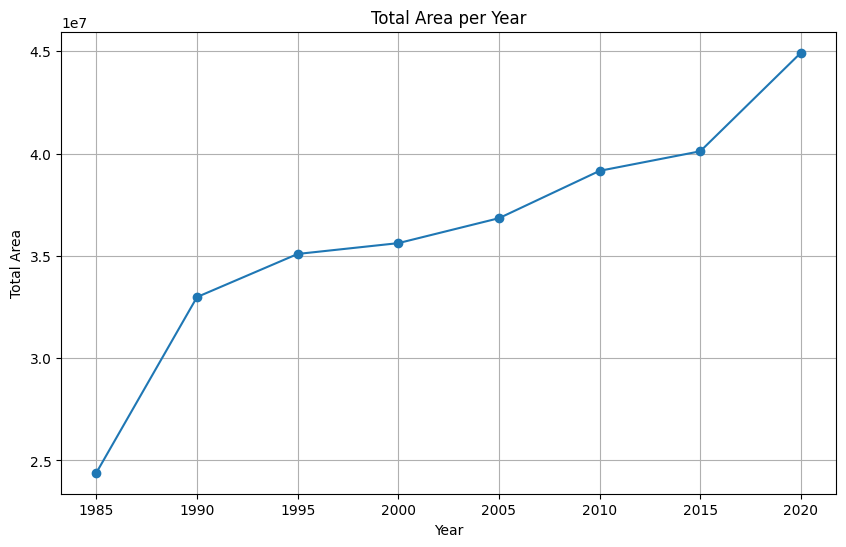

In [56]:
gpkg_files = glob.glob('/workspaces/mine-segmentation/data/interim/*.gpkg')

plot_area_per_year(gpkg_files)